In [1]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("2021-2023.csv")
data["Call Date"] = pd.to_datetime(data["Call Date"])
data = data[data["Neighborhooods - Analysis Boundaries"] == "Chinatown"]

/var/folders/yk/qg5wffwx34v9_s9yt694z1400000gn/T/ipykernel_17851/477423172.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("2021-2023.csv")


In [5]:
result = data.groupby('Call Date').nunique().reset_index().sort_values(by='Call Date')
result

,Call Date,Call Number,Unit ID,Incident Number,Call Type,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,data_loaded_at,Analysis Neighborhoods
0,2021-01-02,12,13,12,3,1,12,12,14,20,...,1,5,3,1,1,1,20,10,1,1
1,2021-01-03,4,6,4,2,1,4,4,5,8,...,1,5,3,1,1,1,8,4,1,1
2,2021-01-04,7,10,7,2,2,7,7,8,15,...,1,5,3,1,1,1,15,7,1,1
3,2021-01-05,10,14,10,2,1,10,10,11,20,...,1,5,3,1,1,1,20,9,1,1
4,2021-01-06,7,10,7,2,2,7,7,7,12,...,1,6,3,1,1,1,12,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,2023-12-02,11,13,11,2,2,11,11,11,21,...,1,5,3,1,1,1,21,11,1,1
1065,2023-12-03,9,14,9,3,2,9,9,14,23,...,1,6,4,1,1,1,23,8,1,1
1066,2023-12-04,13,23,13,3,2,13,13,20,39,...,1,10,12,1,1,1,39,12,1,1
1067,2023-12-05,8,13,8,2,2,8,8,11,17,...,1,7,3,1,1,1,17,8,1,1


In [6]:
df = result.copy()[["Call Date", "Call Number"]]
df

,Call Date,Call Number
0,2021-01-02,12
1,2021-01-03,4
2,2021-01-04,7
3,2021-01-05,10
4,2021-01-06,7
...,...,...
1064,2023-12-02,11
1065,2023-12-03,9
1066,2023-12-04,13
1067,2023-12-05,8


In [99]:
import pandas as pd
from prophet import Prophet
train, test = df.iloc[:500], df.iloc[500:700]

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

#m = Prophet(interval_width = 0.2, weekly_seasonality = 7, yearly_seasonality = 20)
m = Prophet(holidays = lockdowns, interval_width = 0.9, weekly_seasonality = 7, yearly_seasonality = 20)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
p_data = train[["Call Date", "Call Number"]]
p_data = p_data.rename(columns = {"Call Date": "ds", "Call Number": "y"})
m.fit(p_data)

18:19:44 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
future = m.make_future_dataframe(periods=200)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
695,2022-11-28,8.908725,4.644080,13.469017
696,2022-11-29,8.357767,3.849316,12.532784
697,2022-11-30,7.734972,3.514131,11.958854
698,2022-12-01,8.132176,3.912687,12.343882
699,2022-12-02,8.486985,4.347382,12.454869


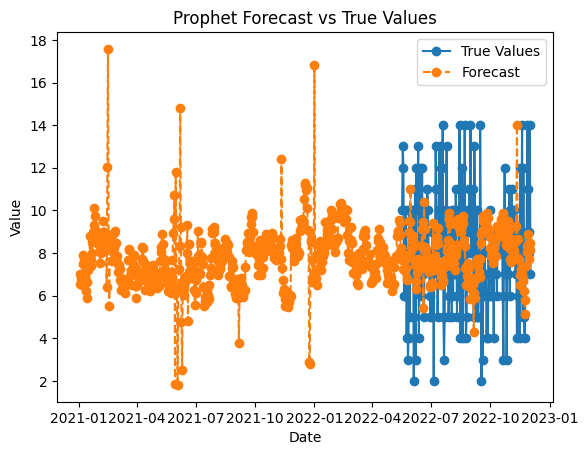

In [101]:
#fig1 = m.plot(forecast)
p_real = test[["Call Date", "Call Number"]]
p_real = p_real.rename(columns = {"Call Date": "ds", "Call Number": "y"})

plt.plot(p_real['ds'], p_real['y'], label='True Values', marker='o')

# Plot the forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='dashed', marker='o')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast vs True Values')
plt.legend()
plt.show()

In [42]:
my_data = p_data.copy()
my_data["y"] = my_data["y"].shift(7)
my_data = my_data.dropna()
my_data

,ds,y
7,2021-01-09,12.0
8,2021-01-10,4.0
9,2021-01-11,7.0
10,2021-01-12,10.0
11,2021-01-13,7.0
...,...,...
724,2022-12-27,7.0
725,2022-12-28,7.0
726,2022-12-29,18.0
727,2022-12-30,10.0


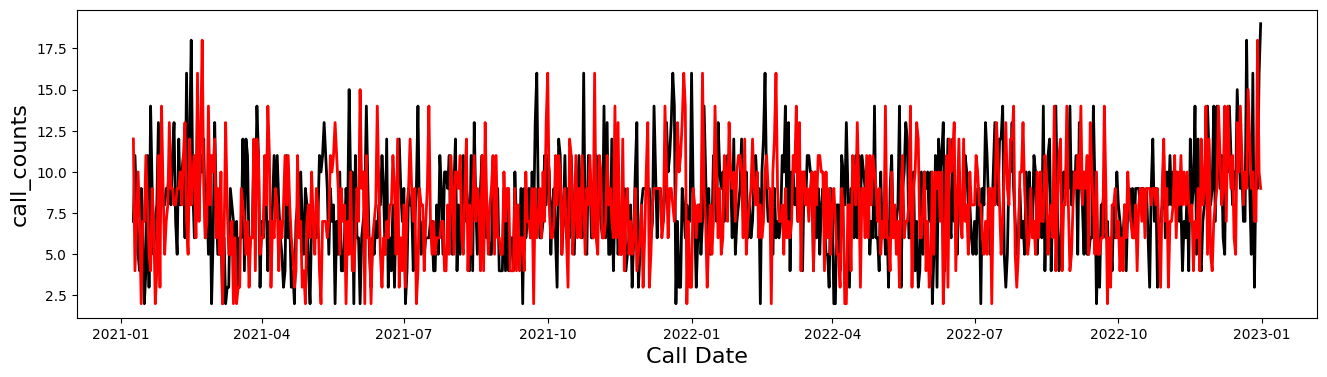

In [44]:
def plot_entire_series(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
        
    plt.xlabel('Call Date', fontsize=16)
    plt.ylabel('call_counts', fontsize=16)
    plt.show()
    
    return None

x = p_data["ds"].iloc[7:]
y = p_data["y"].iloc[7:]

plot_entire_series(x, y, red = my_data["y"])

In [46]:
from sklearn.metrics import r2_score

# Here we slice the series using [1:] in order to discard the first entry which corresponds to a NaN.
print('Training R2:', round(r2_score(y, my_data["y"]), 5))
#lol rip r2

Training R2: -0.87492
